tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Test Accuracy: 0.9904
Macro F1 Score: 0.9904
Macro ROC AUC: 0.9999


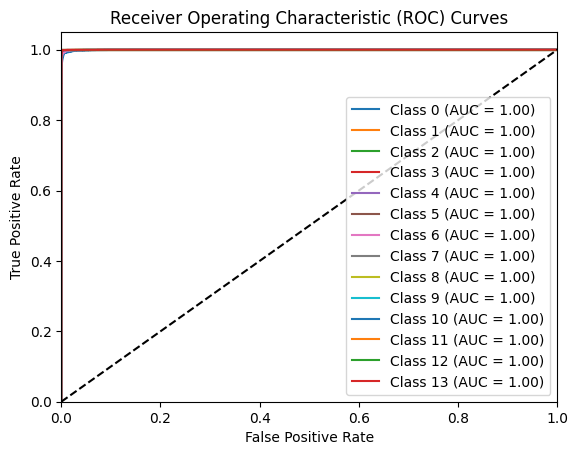

In [1]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        text_column = 'content' if 'content' in df.columns else 'title'
        self.texts = df[text_column].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

class EPASSModel(nn.Module):
    def __init__(self, base_model, num_classes, projector_dim=128, num_projectors=3):
        super(EPASSModel, self).__init__()
        self.encoder = base_model  # Pretrained BERT
        self.projectors = nn.ModuleList([
            nn.Sequential(
                nn.Linear(768, projector_dim),
                nn.ReLU(),
                nn.Linear(projector_dim, num_classes)
            ) for _ in range(num_projectors)
        ])

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            features = self.encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        projections = torch.stack([proj(features) for proj in self.projectors], dim=0)
        ensemble_output = torch.mean(projections, dim=0)
        return ensemble_output

def evaluate(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask)  
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

def plot_roc(all_labels, all_probs, n_classes):
    labels_binarized = label_binarize(all_labels, classes=list(range(n_classes)))
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = roc_auc_score(labels_binarized[:, i], all_probs[:, i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert_model = BertModel.from_pretrained("bert-base-uncased")

    test_path = '/kaggle/input/dbpedia/test.csv'  
    model_path = '/kaggle/input/epass_text/pytorch/default/1/epass_model_full.pth' 

    test_df = pd.read_csv(test_path)
    test_dataset = TextDataset(test_df, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    torch.serialization.add_safe_globals([BertModel, EPASSModel])

    model = torch.load(model_path, map_location=device, weights_only=False)
    model.to(device)

    all_labels, all_preds, all_probs = evaluate(model, test_loader, device)

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    n_classes = len(np.unique(all_labels))
    try:
        auc = roc_auc_score(
            label_binarize(all_labels, classes=list(range(n_classes))),
            all_probs,
            multi_class='ovr',
            average='macro'
        )
    except Exception as e:
        auc = None
        print("ROC AUC could not be computed:", e)

    print("Test Accuracy: {:.4f}".format(accuracy))
    print("Macro F1 Score: {:.4f}".format(f1))
    if auc is not None:
        print("Macro ROC AUC: {:.4f}".format(auc))

    plot_roc(all_labels, all_probs, n_classes)

if __name__ == "__main__":
    main()
